In [853]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
from __future__ import unicode_literals
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [854]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaimemillan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Setup The enviromental modules

### Import nltk

In [887]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words(['english','danish', 'dutch', 'english', 'finnish', 'french', 'german', 'hungarian', 'italian', 'norwegian', 'portuguese', 'russian', 'spanish', 'swedish', 'turkish'])
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Get The podcast Data 

### Here we import the podcast data. At the end we will have about ~100k podcast to utilize for our prediction model. 
### This csv files offer the following information regarding the podcasts:

- podcast description from url and itunes (str)
- podcast urls (str)
- podcast explicit content (boolean)
- podcast name 
- podcast picture

## Import the files Now! 
### first create string from a- to -z so we can import them!

In [888]:
import string 
strings = string.ascii_lowercase[1:26]
print(strings)

bcdefghijklmnopqrstuvwxyz


In [857]:
#new_df.columns = ['a', 'b','c','d','e','f','g','h','i','j','k','l']

In [858]:
df = pd.read_csv("a.csv",header=None)
#df = pd.read_csv("all.csv")
#new_df = pd.read_csv('J_tsar_tweets.csv')

In [859]:
new_col = df.columns

## Import big files with podcasts

In [890]:
df = pd.read_csv("all.csv",header=None)
df.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')

## Dictionary from numerical colums to podcast descriptions!

In [891]:
dict_num_colnames = {'slug':0,'name':1,'image_url':2,'feed_url':3,'website_url':4,
                      'itunes_owner_name':5,'itunes_owner_email':6,
                        'description':10,'itunes_summary':11}

In [892]:
dict_num_colnames = {'slug':0,'name':2,'image_url':3,'feed_url':4,'website_url':5,
                      'itunes_owner_name':6,'itunes_owner_email':7,
                        'description':11,'itunes_summary':12}

In [893]:
df.iloc[:10,11]

0                                                   10
1    A플러스처치는 독일 다름슈타트에 있는 아름다운교회입니다.&#xD;\r\n청년유학생 ...
2    A new project dedicated to all lovers of elect...
3    We chat about the movies, TV and pop-culturey ...
4    <br>Pooopup.com 節目［A基B48 (AGAYB48)]</br>\n<br>...
5    Florence Augusta Merriam Bailey was an America...
6    A radio show that plays bluegrass, old time an...
7    A blend of soul,pop,funk,rhythm and blues and ...
8                                                  NaN
9           Another great podcast hosted by LibSyn.com
Name: 11, dtype: object

In [894]:
nbr_data =1000

## Let's Clean the podcast

### Some podcast description is misssing, or in asian languages hard to deal with. For now we will focus on English.
### Suggestion: Extend this analysis to other languages in the future




In [895]:
#Backup file to start cleaning process

new_df = pd.DataFrame({'content':df.iloc[:,dict_num_colnames['description']],    
                       'content2':df.iloc[:,dict_num_colnames['itunes_summary']],
                       'name': df.iloc[:,dict_num_colnames['name']],
                       'website_url': df.iloc[:,dict_num_colnames['website_url']]
                      })

In [906]:
bad_ids= []
good_ids = []
data = new_df.content[:].values.tolist()
data1 = new_df.content2[:].values.tolist()
pod_names = new_df.name[:].values.tolist()
pod_url = new_df.website_url[:].values.tolist()
#data = new_df.text[2:nbr_data].values.tolist()
new_data = []
for idx,_sentence in enumerate(data):
    
    if isinstance(_sentence,float):
        bad_ids.append(idx)
        continue
        
    tokens = _sentence.split()
    new_string = str()
    
    ADD_STRING = True
    for t in tokens:
        try:
            t.encode('utf-8')
            
            new_string = new_string +  t.encode('utf-8')+ ' '
            
        except:
            bad_ids.append(idx)
            ADD_STRING = False
            break
    if ADD_STRING:
        new_data.append(new_string)
        good_ids.append(idx);
   
print(len(bad_ids))
print(len(good_ids))

37030
92697


In [905]:
#bad_ids= []
#good_ids = []
data = new_df.content[:].values.tolist()
data1 = new_df.content2[:].values.tolist()
pod_names = new_df.name[:].values.tolist()
pod_url = new_df.website_url[:].values.tolist()
#data = new_df.text[2:nbr_data].values.tolist()
new_data = []

def clean_asian(streamdata):
    bad_ids= []
    good_ids = []
    for idx,_sentence in enumerate(streamdata):

        if isinstance(_sentence,float):
            bad_ids.append(idx)
            continue

        tokens = _sentence.split()
        new_string = str()

        ADD_STRING = True
        for t in tokens:
            try:
                t.encode('utf-8')

                new_string = new_string +  t.encode('utf-8')+ ' '

            except:
                bad_ids.append(idx)
                ADD_STRING = False
                break
        if ADD_STRING:
            new_data.append(new_string)
            good_ids.append(idx);
    
    return good_ids,bad_ids;

good_ids, bad_ids = clean_asian(data)

print(len(good_ids))
print(len(bad_ids))

92697
37030


In [897]:
final_df =new_df.loc[:].drop(bad_ids)
data = list(new_data)
size =len(final_df);
new_index = [i for i in range(size)]
final_df.index = new_index
len(new_data)

92697

In [902]:

def clean_weird_chars(stream_data):
    new_data = []
    for idx,sentence in enumerate(stream_data):
        new_sentence=str()
        try:

            new_sentence =  re.sub('\S*@\S*\s?', '', sentence)

        except:
             continue;

        try:

            new_sentence =  re.sub('\s+', ' ', new_sentence)

        except:
             continue;   

        try:

            new_sentence =  re.sub("\'", "", new_sentence)

        except:
             continue;

        new_data.append(new_sentence)

    return new_data;
new_data = clean_weird_chars(data)




92697


In [868]:
#final_df.content

In [900]:
# Convert to list

#data = new_df.content[:50].values.tolist()


# Remove Emails
new_data = []
for idx,sentence in enumerate(data):
    new_sentence=str()
    try:
        
        new_sentence =  re.sub('\S*@\S*\s?', '', sentence)
        
    except:
         continue;
            
    try:
        
        new_sentence =  re.sub('\s+', ' ', new_sentence)
        
    except:
         continue;   
    
    try:
        
        new_sentence =  re.sub("\'", "", new_sentence)
        
    except:
         continue;

    new_data.append(new_sentence)
    
     
# Remove email
#new_sentence =  re.sub('\S*@\S*\s?', '', sentence)

# Remove new line characters
#new_sentence =  re.sub('\s+', ' ', new_sentence)

# Remove distracting single quotes
#new_sentence =  re.sub("\'", "", new_sentence)

#pprint(new_data[:])


92697
92697


In [870]:
data = new_data
final_df.content = data
len(data)


92697

In [535]:
data[:10]

[u'10 ',
 u'A new project dedicated to all lovers of electronic music ',
 u'We chat about the movies, TV and pop-culturey stuff ',
 u'Florence Augusta Merriam Bailey was an American ornithologist and nature writer. She started observing bird behavior at a time when most bird study was based on collections and skins. By 1885, she began to write articles focusing on protecting birds. Her introduction of a birdwatching field guide, aimed at living birds, is considered the first in the tradition of modern bird guides. She wrote the first of these at the age of 26, initially as a series of notes in the Audubon Magazine and later as books. In "A-Birding on a Bronco," she writes an engaging memoir about her several trips to study birds on a ranch in California in the late 1800s. ',
 u'A radio show that plays bluegrass, old time and gospel music only by unsigned bands and discusses their playing style. ',
 u'A blend of soul,pop,funk,rhythm and blues and rock : songs by Musilosophy, singer song

In [284]:
def sent_to_words(sentences):
    for sentence in sentences:
        
        try:
            a = gensim.utils.simple_preprocess(str(sentence), deacc=True)
            
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        except:
            
            continue
        
data_words = list(sent_to_words(data))

print(data_words[:2])
del data_words[0]

[[u'new', u'project', u'dedicated', u'to', u'all', u'lovers', u'of', u'electronic', u'music'], [u'we', u'chat', u'about', u'the', u'movies', u'tv', u'and', u'pop', u'culturey', u'stuff']]


In [28]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/Users/jaimemillan/miniconda2/lib/python2.7/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


[u'florence', u'augusta', u'merriam', u'bailey', u'was', u'an', u'american', u'ornithologist', u'and', u'nature', u'writer', u'she', u'started', u'observing', u'bird', u'behavior', u'at', u'time', u'when', u'most', u'bird', u'study', u'was', u'based', u'on', u'collections', u'and', u'skins', u'by', u'she', u'began', u'to', u'write', u'articles', u'focusing', u'on', u'protecting', u'birds', u'her', u'introduction', u'of', u'birdwatching', u'field', u'guide', u'aimed', u'at', u'living', u'birds', u'is', u'considered', u'the', u'first', u'in', u'the', u'tradition', u'of', u'modern', u'bird', u'guides', u'she', u'wrote', u'the', u'first', u'of', u'these', u'at', u'the', u'age', u'of', u'initially', u'as', u'series', u'of', u'notes', u'in', u'the', u'audubon', u'magazine', u'and', u'later', u'as', u'books', u'in', u'birding', u'on', u'bronco', u'she', u'writes', u'an', u'engaging', u'memoir', u'about', u'her', u'several', u'trips', u'to', u'study', u'birds', u'on', u'ranch', u'in', u'califo

In [29]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [30]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en')

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:10])

[[u'florence', u'augusta', u'merriam', u'bailey', u'american', u'ornithologist', u'nature', u'writer', u'start', u'observe', u'bird', u'behavior', u'time', u'bird', u'study', u'base', u'collection', u'skin', u'begin', u'write', u'article', u'focus', u'protect', u'bird', u'introduction', u'birdwatching', u'field', u'guide', u'aim', u'live', u'bird', u'consider', u'first', u'tradition', u'modern', u'bird', u'guide', u'write', u'first', u'age', u'initially', u'series', u'note', u'magazine', u'later', u'book', u'bird', u'bronco', u'write', u'engage', u'memoir', u'several', u'trip', u'study', u'bird', u'ranch', u'california', u'late'], [u'radio', u'show', u'play', u'bluegrass', u'old', u'time', u'gospel', u'music', u'unsigned', u'band', u'discuss', u'play', u'style'], [u'blend', u'soul', u'pop', u'funk', u'rhythm', u'blue', u'rock', u'song', u'musilosophy', u'singer', u'songwriter', u'jazz', u'pianist', u'lt_br', u'gt'], [u'great', u'podcast', u'host', u'libsyn'], [u'semi', u'weekly', u'dis

In [ ]:
#Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

In [ ]:
id2word[1]

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [ ]:
len(corpus)





In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=400,
                                           update_every=100,
                                           chunksize=10,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

In [ ]:
N_TOPICS = 10
lsi_model = gensim.models.LsiModel(corpus=corpus, num_topics=N_TOPICS, id2word=id2word)

In [ ]:
# Compute Perplexity
#print('\nPerplexity: ', lsi_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
print("LSI Model:")
 
for idx in range(N_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lsi_model.print_topic(idx, 10))
 
print("=" * 20)

In [ ]:
N_TOPICS = 5
lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=N_TOPICS, id2word=id2word)

In [ ]:
print("LDA Model:")
 
for idx in range(N_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))
 
print("=" * 20)

In [ ]:
test_data = pd.read_csv('J_tsar_tweets.csv')
test_data.columns

In [11]:
text = test_data.text.values

NameError: name 'test_data' is not defined

In [12]:
# Convert to list

#data = new_df.content[:50].values.tolist()


# Remove Emails
new_data = []
for idx,sentence in enumerate(text):
    new_sentence=str()
    try:
        
        new_sentence =  re.sub('\S*@\S*\s?', '', sentence)
        
    except:
         continue;
            
    try:
        
        new_sentence =  re.sub('\s+', ' ', new_sentence)
        
    except:
         continue;   
    
    try:
        
        new_sentence =  re.sub("\'", "", new_sentence)
        
    except:
         continue;

    new_data.append(new_sentence)

NameError: name 'text' is not defined

In [13]:
new_data[:2]

[]

In [14]:
string_text = list()
for tweet in new_data[:20]:
    tokens = tweet.split()
    
    string_text += tokens
    
#print(string_text)

In [15]:


bow = id2word.doc2bow(string_text)
 
print(lda_model[bow])
# [(0, 0.091615426138426506), (1, -0.0085557463300508351), (2, 0.016744863677828108), (3, 0.040508186718598529), (4, 0.014201267714185898), (5, -0.012208538275305329), (6, 0.031254053085582149), (7, 0.017529584659403553), (8, 0.056957633371540077),
#(9, 0.025989149894888153)]
 
#print(lda_model[bow])

NameError: name 'id2word' is not defined

In [16]:
print(lsi_model[bow])

NameError: name 'lsi_model' is not defined

In [17]:
top_words_per_topic = []
for t in range(lda_model.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in lda_model.show_topic(t, topn = 20)])

pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("top_words.csv")

NameError: name 'lda_model' is not defined

In [18]:
top_words_lda = pd.read_csv('top_words.csv')

In [39]:
top_words_lda

,Unnamed: 0,Topic,Word,P
0,0,0,right,0.024787
1,1,0,series,0.022096
2,2,0,show,0.020418
3,3,0,quot,0.015878
4,4,0,episode,0.013829
5,5,0,hard,0.012986
6,6,0,christma,0.012983
7,7,0,keep,0.011998
8,8,0,audio,0.011799
9,9,0,get,0.011732


In [488]:
data[:3]

[u'9 ', u'False ', u'False ']

In [871]:
from sklearn.neighbors import KNeighborsClassifier
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

In [879]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer



#data = [u'hello I love you more hi bye',u'hello I love you more hi bye say ', u'hello I love you more hi bye class class',u'create a python sql cpp',u'contact your mom dad son']
y = [int(1) for i in range(len(data))]

#X_test = [u'The people of Germany are turning against their leadershipas migration is rocking the already tenuous Berlin coalition. Crime in Germany is way up. Big mistake made all over Europe in allowing millions of people in who have so strongly and violently changed their culture!t!']
#X_test = [u'fussball fussball']
#X_test = ['Hey Joe,Wondering why this website: http://www.iiseagrant.org/wilmettebuoy/  and this website: http://www.ndbc.noaa.gov/station_page.php?station=45174 … show different wind dir / speed']
X_test =['Low plastic stool, cheap but delicious noodles, cold Hanoi beer.” This is how I’ll remember Tony. He taught us about food — but more importantly, about its ability to bring us together. To make us a little less afraid of the unknown. We’ll miss him.']
# Transform the training data: tfidf_train 
#X_test = ['I live in a border state. border state I appreciate the need to enforce and protect our international boundaries, but this zero-tolerance policy is cruel. It is immoral. And it breaks my heart.']
tfidf_train = tfidf_vectorizer.fit_transform(data)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)
# Initialize a TfidfVectorizer object: tfidf_vectorizer


modelknn = KNeighborsClassifier(n_neighbors=1)
modelknn.fit(tfidf_train,y)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [880]:
a= np.dot(tfidf_test,tfidf_train.T)
print(a.A)
a_sort = np.argsort(a.A)
print(a_sort)


    

[[0. 0. 0. ... 0. 0. 0.]]
[[    0 60481 60480 ... 34970 86125 65352]]


(0, 50)

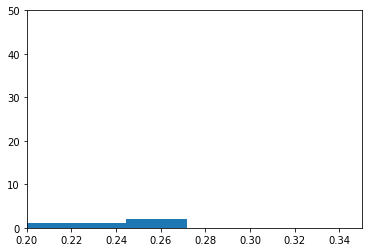

In [881]:
plt.hist(a.A.flatten()[:])
plt.xlim((0.2,0.35))
plt.ylim((0,50))

In [882]:
max_vals_idx =  a_sort.flatten()[::-1][:100]

In [883]:
max_vals_idx

array([65352, 86125, 34970, 31470, 78878, 31436, 87831, 44817, 24360,
       69511, 72278, 20317, 46116, 52301, 70935, 81162, 50469, 64048,
       75528, 87650,  3763, 10912, 59668, 73096, 50926, 45979, 34981,
       56869, 55979, 59383,  1890,  9039, 37095, 16787, 53223, 78392,
       74451, 91082, 15891, 79597, 63904, 19745, 89374, 67129, 90407,
       62167, 15892,  1329,  8478, 15480,   413,  7562,   580,  7729,
       75968, 27493, 34638, 16245, 16244, 80081, 82240, 15880, 15896,
       42432, 15907, 50638, 81439, 35904, 33968, 27655, 40964, 26531,
       35497, 44726, 19212, 61854, 15054, 26524, 12335,  5186, 17331,
       29353, 15900, 63665, 15914, 15913, 51873, 44595, 10075,  2926,
       77099, 38852,  8790,  1641, 26534, 37457, 87576, 15915, 33984,
       69517])

In [884]:
t = final_df.loc[max_vals_idx]

In [885]:
t.website_url[:20]

65352                http://www.supraliminalfilms.com
86125               http://djscenx.universpodcast.com
34970                 http://craftbeernation.org/blog
31470     http://www.blogtalkradio.com/everydaycookin
78878                  http://superbudgetbrothers.com
31436                        http://blog.evernote.com
87831          http://visibledrugs.libsyn.com/webpage
44817                        http://jandapairings.com
24360                    http://chickndickpodcast.com
69511                           http://www.ivoox.com/
72278     http://www.savethecat.com/category/podcasts
20317             http://www.thebryancrabtreeshow.com
46116                     http://www.beerfellows.com/
52301         https://www.facebook.com/deejayerikt.fr
70935                          http://rogueintel.com/
81162    http://feeds.feedburner.com/CTR-ThatFunnyGal
50469                        http://www.beerloons.com
64048                           http://please-bite.me
75528                   http

In [886]:
podcast_descriptions = []
for idx in max_vals_idx:
    podcast_descriptions.append(data[idx]) 

podcast_descriptions[:50]

[u'Teaching you to make films on the cheap...or we&#039;ll die trying. ',
 u'Together, we&#039;ll make the difference ! ',
 u'Cold beer and good friends. ',
 u'Its all about food! Remember, food is my life and life is my food! ',
 u'Cheap games for cheap gamers ',
 u'Remember Everything. ',
 u'Soft Dudes. Cheap beer. ',
 u'Wine. Beer. Food. ',
 u'A free comedy podcast for adults. We&#039;ll make you a better person, or your money back. ',
 u'Podcast Remember Me! ',
 u'The Last Website on Screenwriting You&#039;ll Ever Need ',
 u'The longer you listen, the smarter you&#039;ll get ',
 u'Its all about beer ',
 u'French DJ, Deejay Erik T ll Resident Le Guss (Cholet, FR) Every Week ll #MSNS. ',
 u'The most interesting degenerates you&#039;ll ever hear. ',
 u'Join me, Kiera Giordan, every week as I interview comics and other people in the business of being funny. We&apos;ll be talking about the journey of the comics. The highs and the lows. We&apos;ll get personal about what a comic&apos;s l

In [809]:
data[0]

u'10 '

In [810]:

modelknn.predict(tfidf_test)

array([1])

In [811]:
a.A

array([[0., 0., 0., ..., 0., 0., 0.]])

In [812]:
test_data = pd.read_csv('J_tsar_tweets.csv')

In [813]:
test_tweet = test_data.text.tolist()

In [712]:
test_tweet[11]

"Ain't no love in the heart of the city, stay safe people"

In [713]:
for i in range(10):
    test_str =  test_str + test_tweet[i] + " "

In [714]:
test_str

u'@MelloChamp and they what "god hates dead people?" Or victims of tragedies? Lol those people are cooked RT @muftimenk: Attitude can take away your beauty no matter how good looking you are or it could enhance your beauty, making you adorable. I\'m a stress free kind of guy Nowadays everybody wanna talk like they got somethin to say but nothin comes out when they move their lips; just a bunch of gibberish @ImRealTed fake story So then I says to him, I says, relax bro my beard is not loaded @therealAbdul_ #heavy I\'ve been looking for those, there is a shortage on the black market if you wanna make a quick buck, nuff said.. @therealAbdul_ you need to get Claritin clear There are people that know the truth but stay silent &amp; there are people that speak the truth but we don\'t hear them cuz they\'re the minority @mellochamp *say @MelloChamp and they what "god hates dead people?" Or victims of tragedies? Lol those people are cooked RT @muftimenk: Attitude can take away your beauty no m